In [15]:
import pandas as pd

# File paths for the uploaded files
train_scores_path = 'train_scores.csv'
train_logs_path = 'train_logs.csv'
sample_submission_path = 'sample_submission.csv'
test_logs_path = 'test_logs.csv'

# Loading the data into Pandas DataFrames
train_scores = pd.read_csv(train_scores_path)   
train_logs = pd.read_csv(train_logs_path)
sample_submission = pd.read_csv(sample_submission_path)
test_logs = pd.read_csv(test_logs_path)

# Display the first few rows of each DataFrame to understand their structure
train_scores.head(), train_logs.head(), sample_submission.head(), test_logs.head()
len(train_scores), len(train_logs), len(sample_submission), len(test_logs)

(2471, 8405898, 3, 6)

In [3]:
import pandas as pd

# Load the data
train_logs_path = 'train_logs.csv'  # Replace with the actual path
train_logs = pd.read_csv(train_logs_path)

# Display the first few rows to understand its structure
print(train_logs.head())


         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1  


In [4]:
# Grouping by user ID and aggregating data
aggregated_data = train_logs.groupby('id').agg({
    'down_time': 'sum',
    'up_time': 'sum',
    'action_time': 'mean',  # Average action time
    'event_id': 'count',    # Count of events
    'cursor_position': 'max',  # Maximum cursor position
    'word_count': 'max'    # Maximum word count
}).reset_index()

# Adding a new feature: total duration (up_time - down_time)
aggregated_data['total_duration'] = aggregated_data['up_time'] - aggregated_data['down_time']

# Display the first few rows of the aggregated data
print(aggregated_data.head())


         id   down_time     up_time  action_time  event_id  cursor_position  \
0  001519c8  2168798234  2169095477   116.246774      2557             1539   
1  0022f953  1273271023  1273546414   112.221271      2454             1676   
2  0042269b  3426641982  3427063183   101.837766      4136             2291   
3  0059420b  1222211589  1222401185   121.848329      1556             1047   
4  0075873a  1805499474  1805813176   123.943896      2531             1402   

   word_count  total_duration  
0         256          297243  
1         323          275391  
2         404          421201  
3         206          189596  
4         252          313702  


In [6]:
# Ensure that 'id' is the index for aggregated data
aggregated_data.set_index('id', inplace=True)

# Recalculate the additional features with 'id' as the index
activity_counts = pd.get_dummies(train_logs['activity']).groupby(train_logs['id']).sum()
space_down_event = (train_logs['down_event'] == 'Space').astype(int).groupby(train_logs['id']).sum()
space_up_event = (train_logs['up_event'] == 'Space').astype(int).groupby(train_logs['id']).sum()
text_changes = (train_logs['text_change'] != 'NoChange').astype(int).groupby(train_logs['id']).sum()

# Merging these features with the aggregated data
extended_features = pd.concat([aggregated_data, activity_counts, space_down_event, space_up_event, text_changes], axis=1)

# Renaming the new columns for clarity
extended_features.rename(columns={0: 'space_down_events', 1: 'space_up_events', 2: 'text_changes'}, inplace=True)

# Resetting index for convenience
extended_features.reset_index(inplace=True)

# Display the first few rows of the extended dataset
print(extended_features.head())


         id   down_time     up_time  action_time  event_id  cursor_position  \
0  001519c8  2168798234  2169095477   116.246774      2557             1539   
1  0022f953  1273271023  1273546414   112.221271      2454             1676   
2  0042269b  3426641982  3427063183   101.837766      4136             2291   
3  0059420b  1222211589  1222401185   121.848329      1556             1047   
4  0075873a  1805499474  1805813176   123.943896      2531             1402   

   word_count  total_duration  Input  Move From [0, 158] To [234, 392]  ...  \
0         256          297243   2010                                 0  ...   
1         323          275391   1938                                 0  ...   
2         404          421201   3515                                 0  ...   
3         206          189596   1304                                 0  ...   
4         252          313702   1942                                 0  ...   

   Move From [923, 1077] To [340, 494]  Move From 

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(extended_features, test_size=0.20, random_state=42)

# Output the size of the training and testing datasets
print("Training Set Size:", train_set.shape)
print("Testing Set Size:", test_set.shape)


Training Set Size: (1976, 61)
Testing Set Size: (495, 61)


In [8]:
# Summary Statistics
print(train_set.describe())


          down_time       up_time  action_time      event_id  cursor_position  \
count  1.976000e+03  1.976000e+03  1976.000000   1976.000000      1976.000000   
mean   2.723741e+09  2.724075e+09    99.960906   3410.969130      2236.889170   
std    1.782005e+09  1.782117e+09    24.580941   1604.027846       970.986165   
min    1.723896e+07  1.725651e+07    14.131749    262.000000       207.000000   
25%    1.567100e+09  1.567313e+09    83.416385   2192.750000      1491.000000   
50%    2.334999e+09  2.335309e+09    96.805660   3101.000000      2006.000000   
75%    3.440922e+09  3.441403e+09   114.573862   4282.000000      2764.000000   
max    2.424430e+10  2.424494e+10   282.612447  12876.000000      7802.000000   

        word_count  total_duration        Input  \
count  1976.000000    1.976000e+03  1976.000000   
mean    390.882085    3.337112e+05  2723.941802   
std     172.109688    1.571591e+05  1201.373838   
min      35.000000    1.754100e+04   230.000000   
25%     255.750

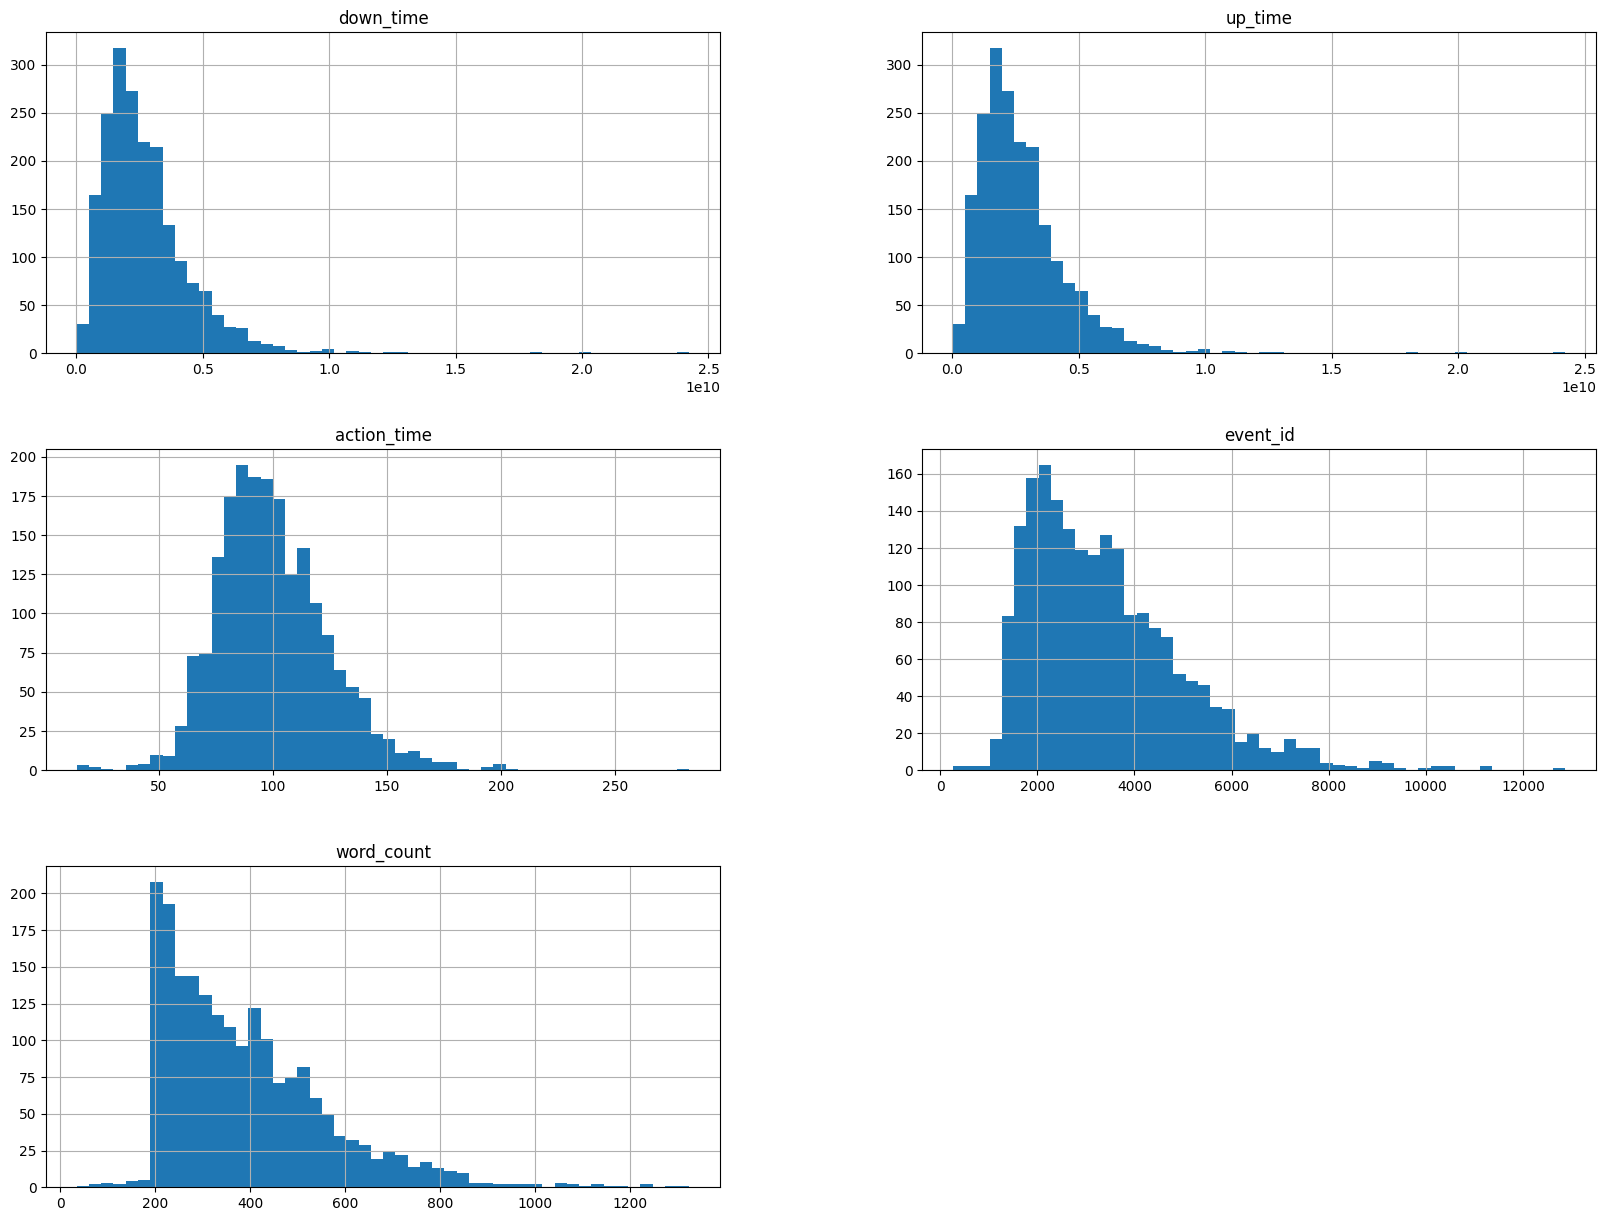

In [9]:
import matplotlib.pyplot as plt

# Histograms for a selection of features
train_set[['down_time', 'up_time', 'action_time', 'event_id', 'word_count']].hist(bins=50, figsize=(20,15))
plt.show()


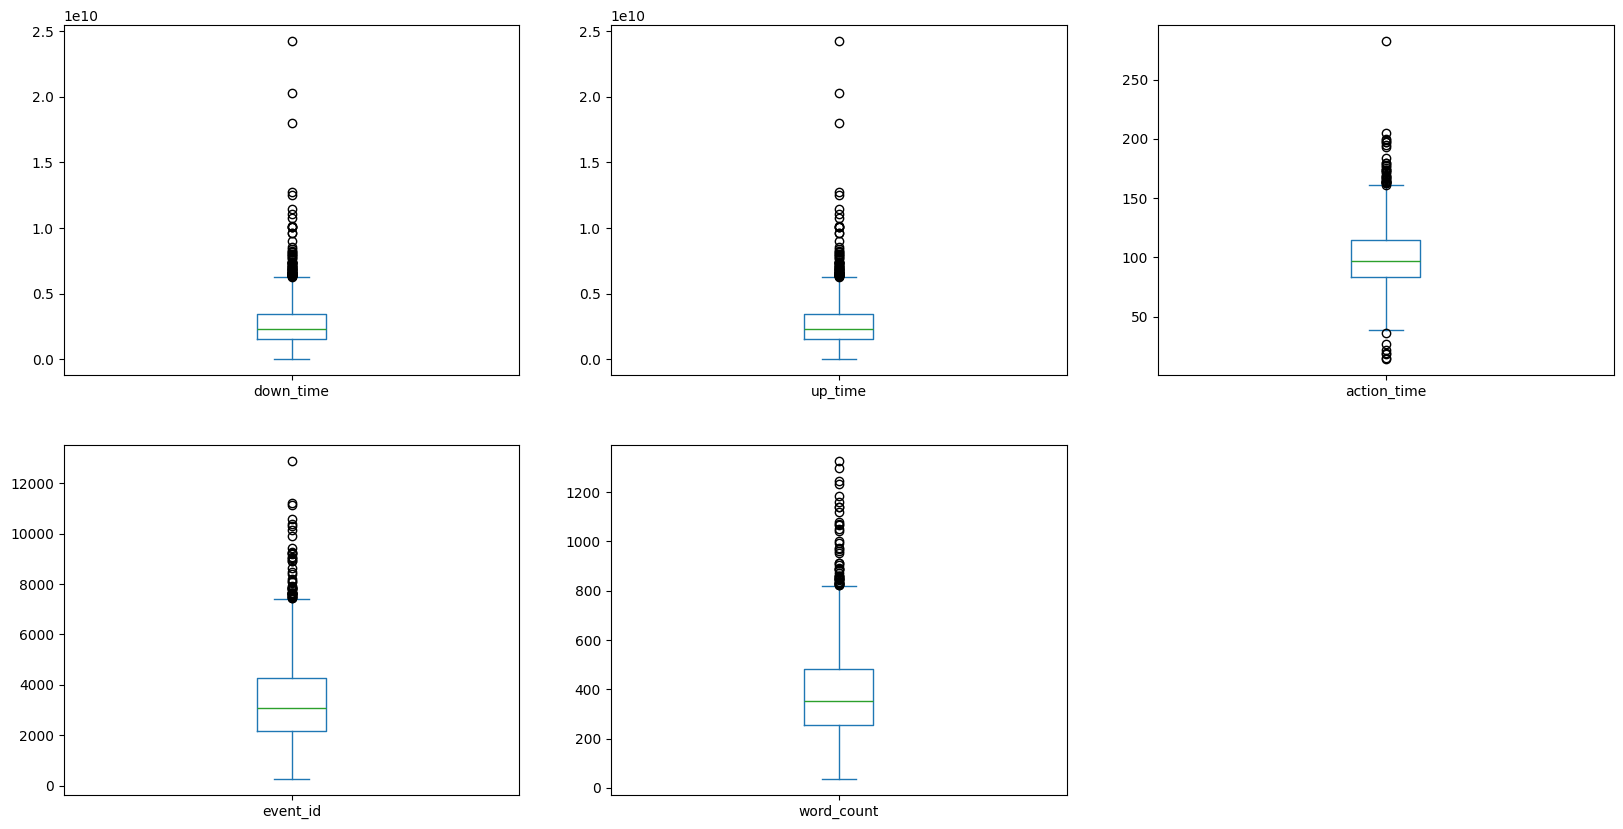

In [10]:
# Box plots for the same selection of features
train_set[['down_time', 'up_time', 'action_time', 'event_id', 'word_count']].plot(kind='box', subplots=True, layout=(2,3), figsize=(20,10))
plt.show()


In [14]:
# Outlier detection for each feature
for feature in features:
    # Calculating Z-scores for the feature
    z_scores = np.abs(stats.zscore(train_set[feature]))

    # Identifying outliers
    outliers = np.where(z_scores > threshold)[0]  # Indices of outliers

    # Printing the first 10 outlier instances for this feature
    print(f"Outliers in feature '{feature}':")
    for i in range(min(len(outliers), 10)):  # Print up to 10 outliers
        data_index = outliers[i]
        outlier_value = train_set.iloc[data_index][feature]
        print(f" - Index {data_index}: {outlier_value}")

    print()  # Newline for readability


Outliers in feature 'down_time':
 - Index 43: 9597560547
 - Index 45: 8285792310
 - Index 69: 11447667969
 - Index 76: 8552132943
 - Index 152: 24244298144
 - Index 268: 8431400807
 - Index 327: 9606339477
 - Index 335: 20316906110
 - Index 401: 8196365605
 - Index 453: 9038832019

Outliers in feature 'up_time':
 - Index 43: 9598112848
 - Index 45: 8286442150
 - Index 69: 11448494742
 - Index 76: 8553057614
 - Index 152: 24244941552
 - Index 268: 8432049500
 - Index 327: 9607027159
 - Index 335: 20317586994
 - Index 401: 8197063068
 - Index 453: 9039744132

Outliers in feature 'action_time':
 - Index 11: 18.77230769230769
 - Index 62: 282.6124469589816
 - Index 128: 177.32552623777053
 - Index 136: 14.131749460043197
 - Index 339: 179.76232821341955
 - Index 450: 179.72976985894582
 - Index 909: 178.06110711718188
 - Index 966: 15.44287330316742
 - Index 1016: 197.2134203168686
 - Index 1033: 194.78163493840987

Outliers in feature 'event_id':
 - Index 43: 10146
 - Index 45: 8410
 - In

In [17]:
extended_features

,id,down_time,up_time,action_time,event_id,cursor_position,word_count,total_duration,Input,"Move From [0, 158] To [234, 392]",...,"Move From [923, 1077] To [340, 494]","Move From [944, 1102] To [1050, 1208]","Move From [999, 1000] To [1000, 1001]",Nonproduction,Paste,Remove/Cut,Replace,down_event,up_event,text_change
0,001519c8,2168798234,2169095477,116.246774,2557,1539,256,297243,2010,0,...,0,0,0,120,0,417,7,357,357,2437
1,0022f953,1273271023,1273546414,112.221271,2454,1676,323,275391,1938,0,...,0,0,0,254,1,260,1,391,391,2200
2,0042269b,3426641982,3427063183,101.837766,4136,2291,404,421201,3515,0,...,0,0,0,175,0,439,7,552,552,3961
3,0059420b,1222211589,1222401185,121.848329,1556,1047,206,189596,1304,0,...,0,0,0,99,1,151,1,243,243,1457
4,0075873a,1805499474,1805813176,123.943896,2531,1402,252,313702,1942,0,...,0,0,0,72,0,517,0,324,324,2459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3488386746,3488886416,105.437856,4739,1634,461,499670,3588,0,...,0,0,0,189,0,960,2,651,651,4550
2467,ffbef7e5,2192480040,2192694261,82.266129,2604,1877,438,214221,2395,0,...,0,0,0,148,0,60,1,447,447,2456
2468,ffccd6fd,3764472937,3764704517,75.605615,3063,2761,201,231580,2849,0,...,0,0,0,126,0,88,0,1861,1861,2937
2469,ffec5b38,1869073112,1869362551,89.277915,3242,2133,413,289439,2895,0,...,0,0,0,71,0,276,0,457,457,3171


In [18]:
from sklearn.model_selection import train_test_split

# Randomly splitting the extended_features dataset
train_data, test_data = train_test_split(extended_features, test_size=0.20, random_state=42)

# Confirming the size of the training and testing datasets
print("Training Data Size:", train_data.shape[0])
print("Testing Data Size:", test_data.shape[0])


Training Data Size: 1976
Testing Data Size: 495


In [19]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaled_features = scaler.fit_transform(extended_features.drop(['id'], axis=1))  # Exclude non-numeric or identifier columns


/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

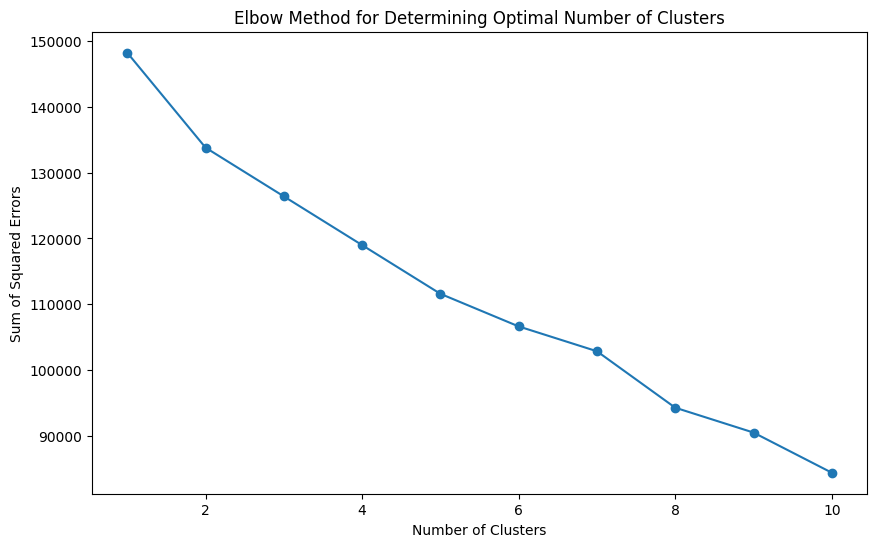

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


sse = []
for k in range(1, 11):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.show()


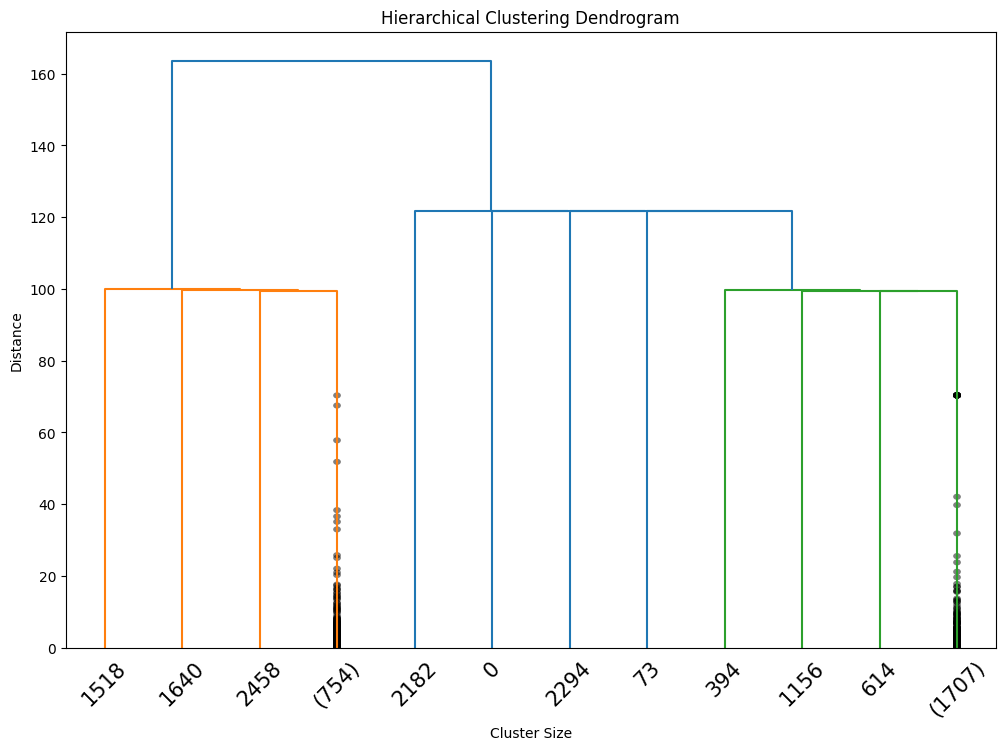

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(scaled_features, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


In [25]:

unsupervised_data = scaled_features



In [26]:
# Assuming kmeans_clusters and hierarchical_clusters are the results from your clustering
extended_features['kmeans_cluster'] = kmeans_clusters  # From K-Means clustering

# For Hierarchical Clustering, you will need to perform the fit_predict step as shown earlier
from sklearn.cluster import AgglomerativeClustering
hierarchical_model = AgglomerativeClustering(n_clusters=3)
extended_features['hierarchical_cluster'] = hierarchical_model.fit_predict(unsupervised_data)


In [28]:
# Assuming that 'extended_features' is the DataFrame with all the features, including cluster labels
# Make sure to exclude non-numeric columns like 'id' or other categorical features
numeric_features = extended_features.select_dtypes(include=[np.number])

# Profile for K-Means clusters
kmeans_profiles = numeric_features.groupby('kmeans_cluster').mean()

# Profile for Hierarchical clusters
hierarchical_profiles = numeric_features.groupby('hierarchical_cluster').mean()

# Now you can print the profiles
print("K-Means Cluster Profiles:\n", kmeans_profiles)
print("\nHierarchical Cluster Profiles:\n", hierarchical_profiles)


K-Means Cluster Profiles:
                    down_time       up_time  action_time     event_id  \
kmeans_cluster                                                         
0               1.862954e+09  1.863209e+09   101.363887  2537.792959   
1               4.467024e+09  4.467522e+09    96.903395  5227.066751   
2               1.459911e+09  1.460256e+09   152.169462  2266.000000   

                cursor_position  word_count  total_duration       Input  \
kmeans_cluster                                                            
0                   1748.552506  305.875895   255428.844869  2071.48926   
1                   3253.977330  567.610831   498802.011335  4097.13728   
2                   1505.000000  276.000000   344816.000000  1853.00000   

                Move From [0, 158] To [234, 392]  \
kmeans_cluster                                     
0                                       0.000597   
1                                       0.000000   
2                           

In [29]:

extended_features = extended_features.join(train_scores.set_index('id'), on='id')


kmeans_outcome_analysis = extended_features.groupby('kmeans_cluster')['score'].mean()
hierarchical_outcome_analysis = extended_features.groupby('hierarchical_cluster')['score'].mean()


In [30]:
hierarchical_outcome_analysis

hierarchical_cluster
0    3.395213
1    4.427345
2    3.000000
Name: score, dtype: float64

In [31]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')


from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_features)


from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')




Silhouette Score: 0.36239037310248357
Davies-Bouldin Index: 0.8746323447577876


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) # Preserve 95% of variance
train_logs_pca = pca.fit_transform(scaled_features)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(scaled_features, kmeans.labels_)
feature_importances = rf.feature_importances_

In [32]:
dbscan_clusters
train_logs_pca

array([[-2.22472521e+00,  3.79450289e+01, -4.76090513e+01, ...,
         8.37199686e-02,  4.47833577e-02,  3.30883825e-01],
       [-1.85658686e+00, -3.78590690e-02,  1.33894680e-03, ...,
         2.36101311e-01, -3.59200312e-01, -1.43879870e-01],
       [ 1.28569198e+00,  2.64467674e-02, -1.39159404e-02, ...,
        -1.15508422e-01, -5.23312571e-02, -3.95354932e-01],
       ...,
       [ 3.08705503e+00, -8.19042546e-02,  9.85899569e-03, ...,
         5.02353051e-01,  2.93693657e-01,  1.56248712e+00],
       [-5.53670113e-01, -6.77230070e-02, -4.74577578e-03, ...,
         7.93993526e-02,  1.61156170e-01,  3.90138706e-01],
       [-1.49911258e-01,  4.70116613e-02, -1.29314200e-01, ...,
         1.41318725e+01,  1.95962948e+01,  4.70732395e+00]])

In [33]:
feature_importances

array([7.55646646e-02, 5.77014898e-02, 6.88676665e-03, 1.39217079e-01,
       5.16414269e-02, 4.57428421e-02, 7.81077217e-02, 1.30029174e-01,
       9.75279190e-05, 6.33810795e-10, 5.34775824e-04, 1.93494310e-05,
       8.89715444e-10, 1.76523689e-09, 0.00000000e+00, 3.97416716e-07,
       8.26413297e-11, 9.90301701e-06, 5.89047149e-09, 1.62331689e-08,
       2.43573434e-09, 2.39034283e-07, 6.90064023e-08, 4.97781249e-05,
       3.63905315e-05, 1.86899337e-09, 7.98303965e-08, 1.76663393e-05,
       1.72486755e-10, 2.98165060e-07, 1.17754278e-05, 7.81600778e-07,
       1.68662400e-06, 0.00000000e+00, 7.00760085e-05, 2.17343803e-05,
       1.06695966e-08, 3.63011368e-05, 7.53098717e-08, 2.72042786e-05,
       4.14229150e-07, 4.28062539e-09, 3.21288326e-04, 1.04601107e-07,
       3.60220971e-07, 8.17216963e-08, 1.35967097e-04, 6.92966760e-04,
       6.15631935e-05, 9.88528245e-08, 5.24327434e-05, 7.52939055e-08,
       2.71799345e-06, 1.74828047e-02, 1.09896858e-03, 1.98087992e-02,
      